# Deep Convolutional GAN (DCGAN)

### Goal
Implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015,using the MNIST dataset.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested!


### DCGAN
Main features of DCGAN : 


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation



In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator



In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator


In [7]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training
Parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type




In [5]:
#parameters
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initialization of the generator, discriminator, and optimizers.

In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialization of the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### Training

Step 500: Generator loss: 1.6090795580744746, discriminator loss: 0.4243279038667678


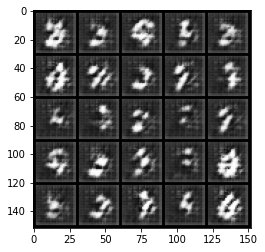

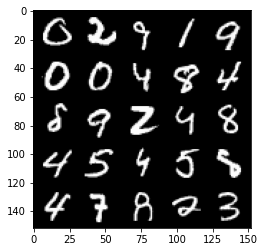

Step 1000: Generator loss: 1.2508391079902648, discriminator loss: 0.49120269942283645


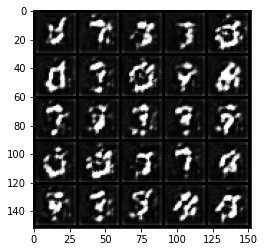

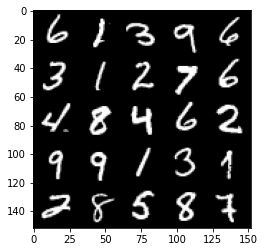

Step 1500: Generator loss: 0.9686104745864866, discriminator loss: 0.5681304579377175


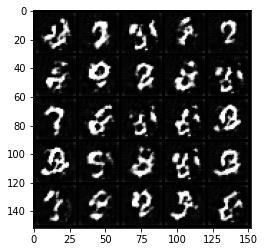

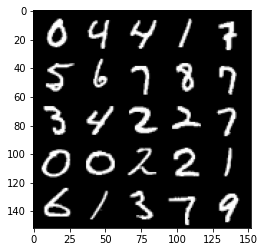

Step 2000: Generator loss: 0.8990024206042289, discriminator loss: 0.6122351986169812


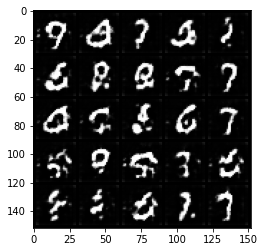

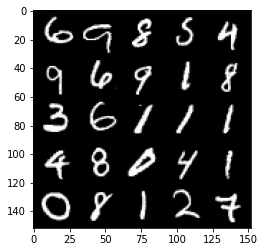

Step 2500: Generator loss: 0.8352993988990789, discriminator loss: 0.6290190991163257


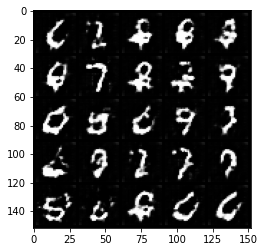

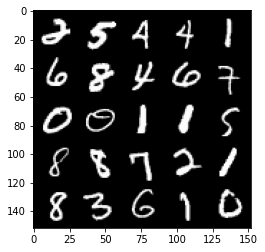

Step 3000: Generator loss: 0.8169467954039573, discriminator loss: 0.6424438738822941


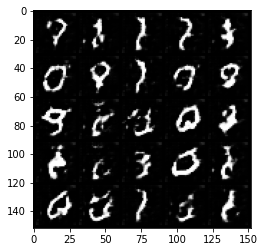

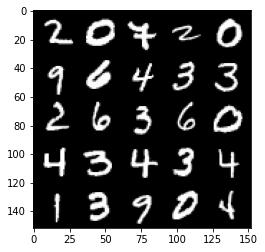

Step 3500: Generator loss: 0.7823179399967193, discriminator loss: 0.6551201193332673


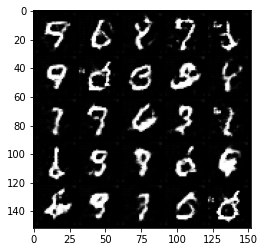

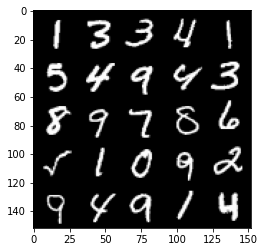

Step 4000: Generator loss: 0.7817397173643117, discriminator loss: 0.6617290240526202


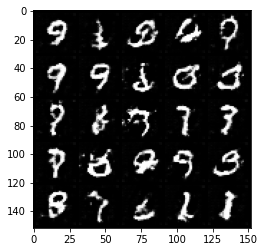

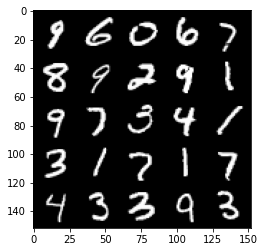

Step 4500: Generator loss: 0.7671944741606711, discriminator loss: 0.6715740611553193


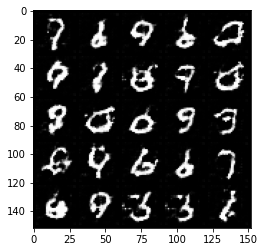

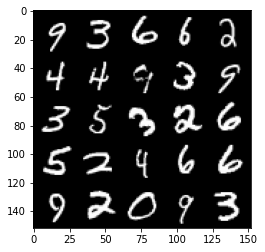

Step 5000: Generator loss: 0.7581215230226519, discriminator loss: 0.6704283348321918


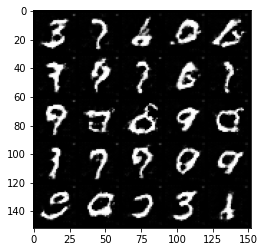

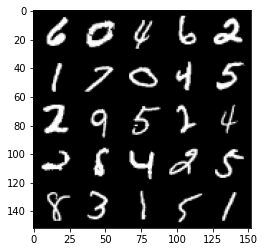

Step 5500: Generator loss: 0.7595572450757027, discriminator loss: 0.6787195631265641


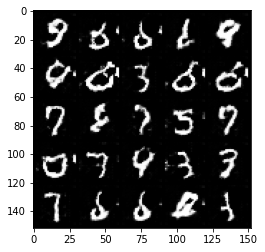

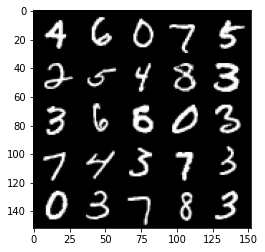

Step 6000: Generator loss: 0.7545275604724889, discriminator loss: 0.6801559554338459


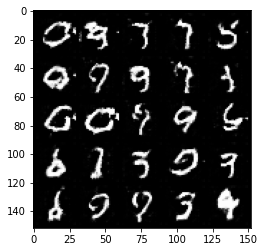

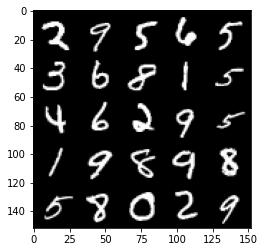

Step 6500: Generator loss: 0.7469632024765024, discriminator loss: 0.6846018164157863


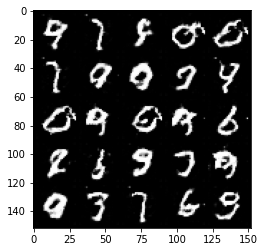

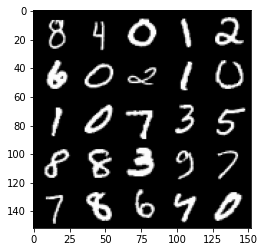

Step 7000: Generator loss: 0.7363135579824457, discriminator loss: 0.6886926445961001


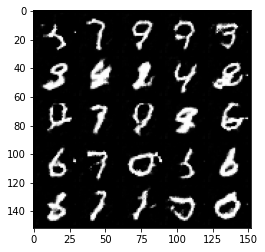

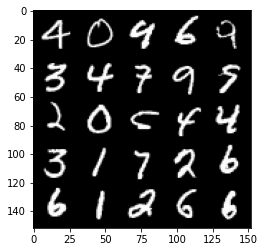

Step 7500: Generator loss: 0.7319890567064288, discriminator loss: 0.6912932777404779


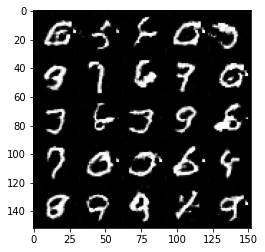

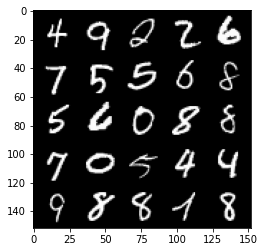

Step 8000: Generator loss: 0.7231148861646647, discriminator loss: 0.6946374315023419


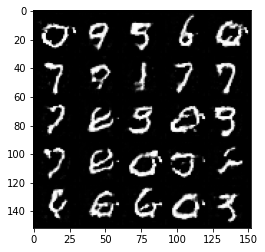

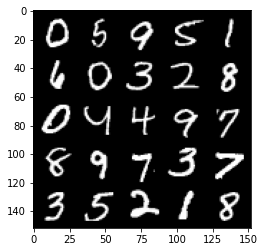

Step 8500: Generator loss: 0.7231353682279595, discriminator loss: 0.6949312195777894


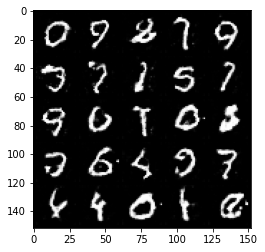

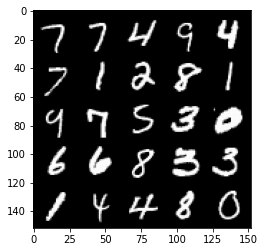

Step 9000: Generator loss: 0.7153603514432915, discriminator loss: 0.6951156525611876


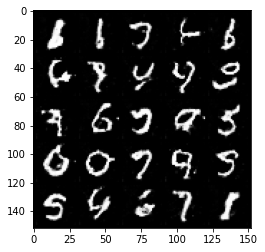

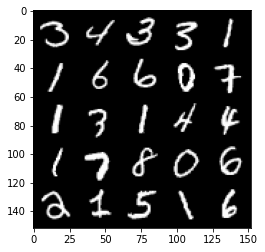

Step 9500: Generator loss: 0.7155945672392849, discriminator loss: 0.6949096751213071


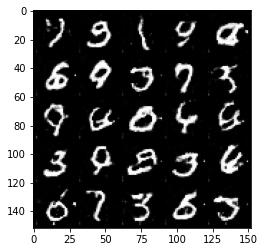

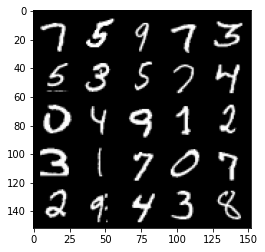

Step 10000: Generator loss: 0.7166268083453173, discriminator loss: 0.6947712831497188


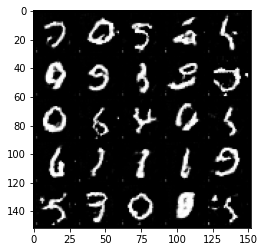

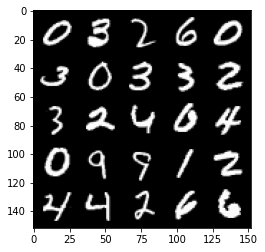

Step 10500: Generator loss: 0.7152897288203237, discriminator loss: 0.6969367141723627


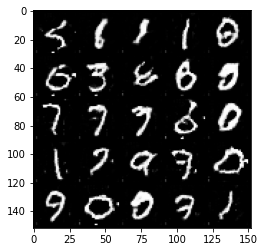

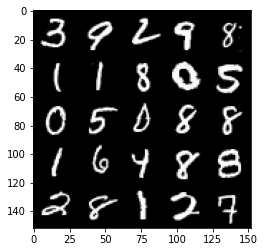

Step 11000: Generator loss: 0.7141720671057699, discriminator loss: 0.6976745808124545


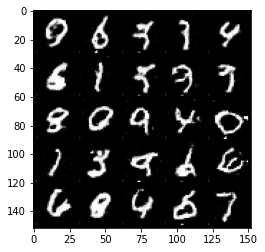

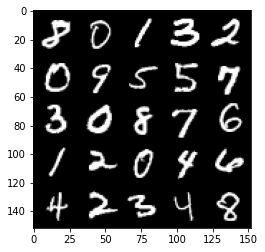

Step 11500: Generator loss: 0.7116391007900232, discriminator loss: 0.6995500179529186


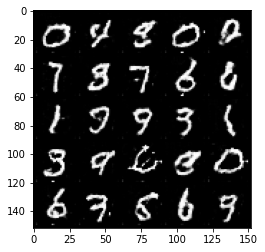

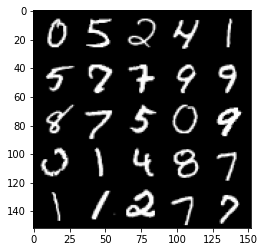

Step 12000: Generator loss: 0.707967528939247, discriminator loss: 0.697862042546272


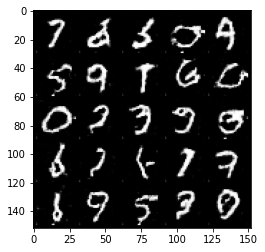

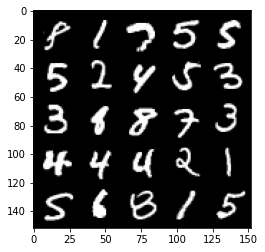

Step 12500: Generator loss: 0.7112437772750856, discriminator loss: 0.6979968400001524


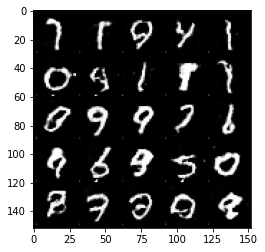

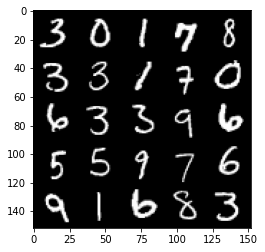

Step 13000: Generator loss: 0.7063608972430222, discriminator loss: 0.6981802580356596


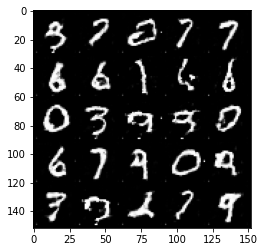

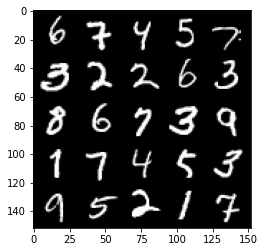

Step 13500: Generator loss: 0.7069817749261861, discriminator loss: 0.6974292294979094


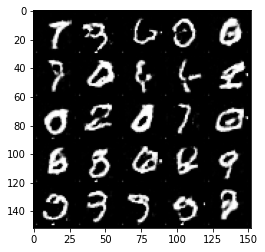

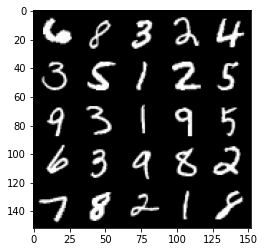

Step 14000: Generator loss: 0.707412409484386, discriminator loss: 0.6979067643880847


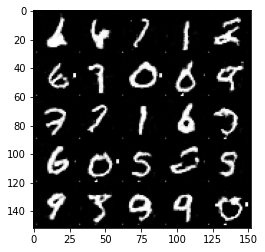

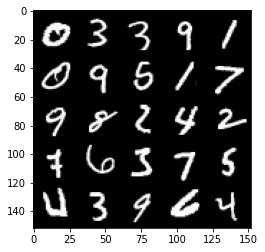

Step 14500: Generator loss: 0.7071023306250567, discriminator loss: 0.6971583398580553


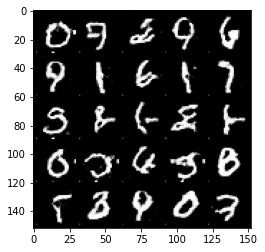

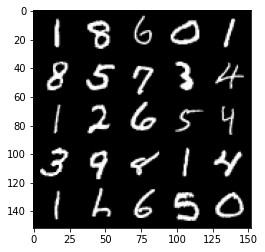

Step 15000: Generator loss: 0.7043321059942244, discriminator loss: 0.6972192130088811


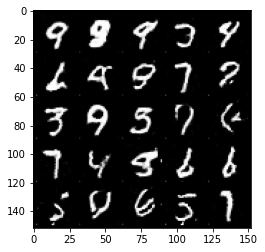

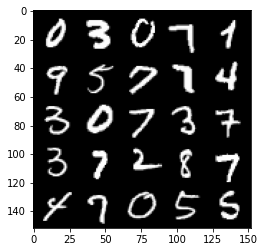

Step 15500: Generator loss: 0.7030805014371871, discriminator loss: 0.6976167442798624


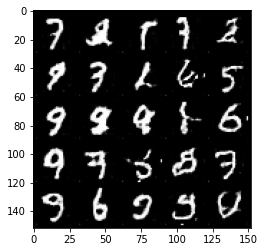

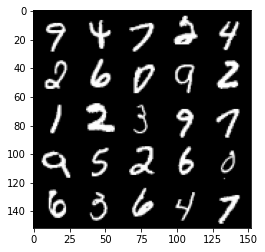

Step 16000: Generator loss: 0.7031248152852058, discriminator loss: 0.6970303852558138


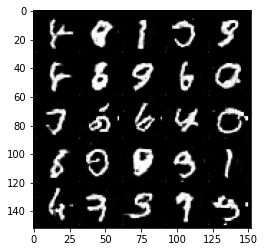

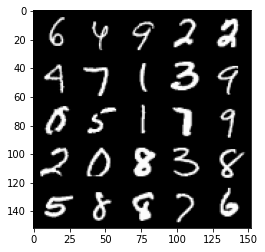

Step 16500: Generator loss: 0.7046294642686838, discriminator loss: 0.6963147940635681


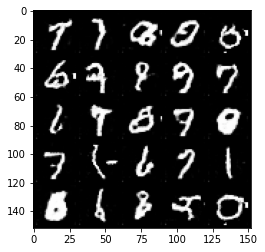

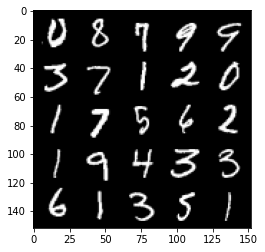

Step 17000: Generator loss: 0.7047133148312577, discriminator loss: 0.6956961938142777


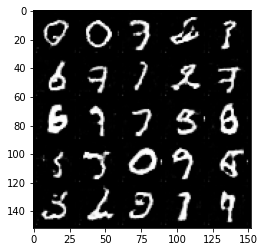

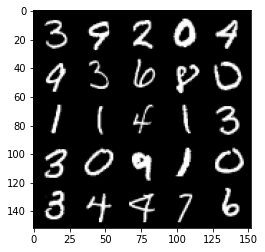

Step 17500: Generator loss: 0.7031414164900779, discriminator loss: 0.6957753480672833


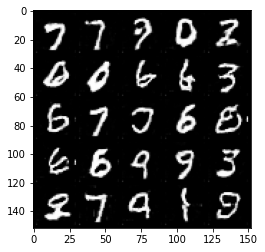

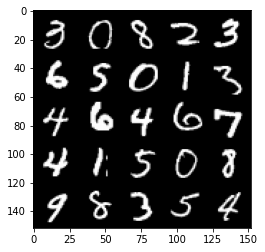

Step 18000: Generator loss: 0.7041292250752453, discriminator loss: 0.6956223646402359


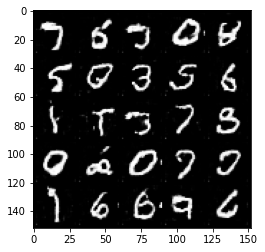

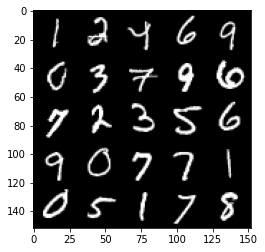

Step 18500: Generator loss: 0.7012946776747696, discriminator loss: 0.6973245784044269


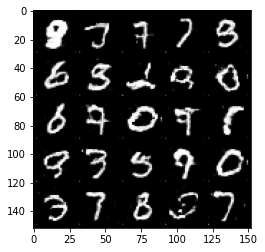

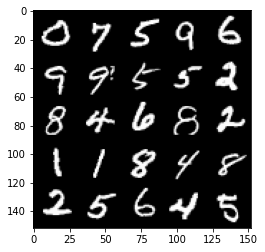

Step 19000: Generator loss: 0.7021980280876159, discriminator loss: 0.6956582666635511


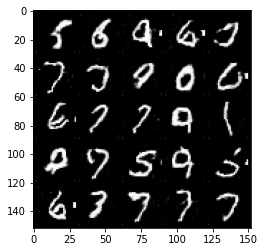

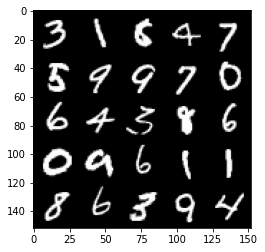

Step 19500: Generator loss: 0.7031418475508686, discriminator loss: 0.695739814043045


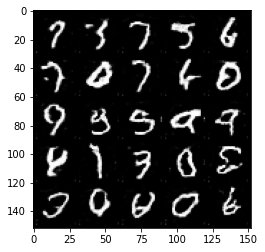

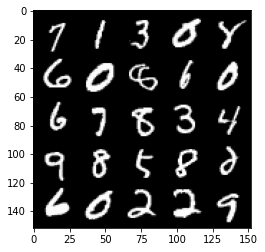

Step 20000: Generator loss: 0.7009942981004716, discriminator loss: 0.6955804797410967


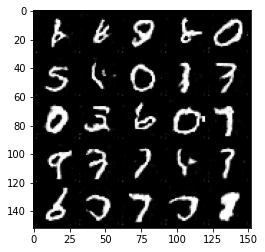

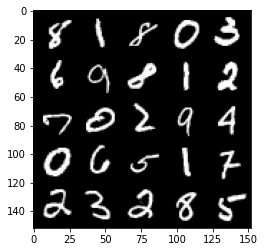

Step 20500: Generator loss: 0.7025845279693603, discriminator loss: 0.695582196354865


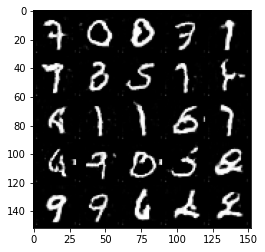

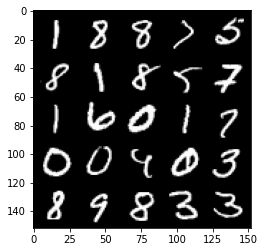

Step 21000: Generator loss: 0.7016618821024897, discriminator loss: 0.6957889465093617


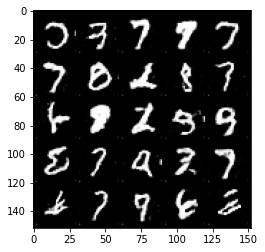

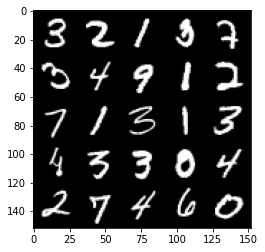

Step 21500: Generator loss: 0.7003073136210446, discriminator loss: 0.6953323394060139


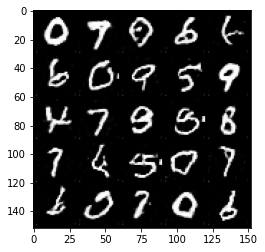

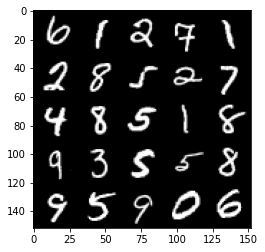

Step 22000: Generator loss: 0.7020728504657742, discriminator loss: 0.6956418131589885


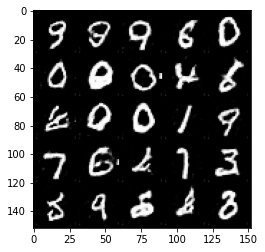

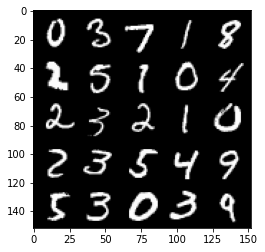

Step 22500: Generator loss: 0.7009359457492832, discriminator loss: 0.6948874616622924


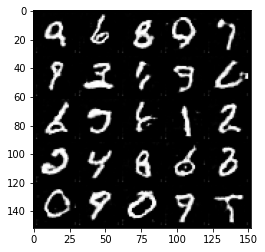

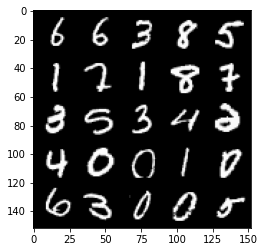

Step 23000: Generator loss: 0.7022166810035708, discriminator loss: 0.69471795129776


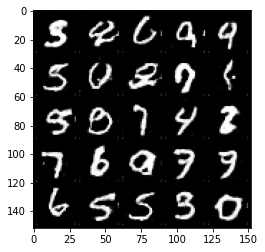

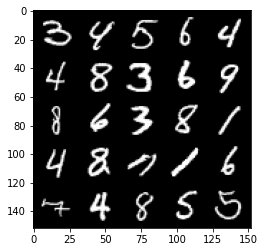

In [11]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
